In [51]:
import pandas as pd
import numpy as np
from tslearn.clustering import TimeSeriesKMeans
from tslearn.preprocessing import TimeSeriesScalerMeanVariance
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from scipy.signal import savgol_filter

In [52]:
df = pd.read_csv("data/ilr_transformed_full_data.csv")

# Define the ilr columns and control columns
ilr_columns = ['ilr1', 'ilr2', 'ilr3']
control_columns = ['excluded', 'injustice', 'personal', 'violence']

# Feature engineering

In [44]:
# Creating -1 and -2 lag features for each ilr variable
for col in ilr_columns:
    df[f'{col}_lag1'] = df.groupby('ID')[col].shift(1)
    df[f'{col}_lag2'] = df.groupby('ID')[col].shift(2)

# Calculate mean and standard deviation per participant (ID) for each ilr column
for col in ilr_columns:
    # Mean per participant
    df[f'{col}_mean'] = df.groupby('ID')[col].transform('mean')
    
    # Standard deviation per participant
    df[f'{col}_std'] = df.groupby('ID')[col].transform('std')
    
    # Minimum and maximum values per participant
    df[f'{col}_min'] = df.groupby('ID')[col].transform('min')
    df[f'{col}_max'] = df.groupby('ID')[col].transform('max')


# Additional time-based feature: time point relative to the total duration for each participant
# This provides a scaled measure of progression within the time series
# df['relative_time'] = df.groupby('ID')['time'].transform(lambda x: x / x.max())


# Optional cumulative feature: cumulative sum of the 'ilr' values within each participant's time series
# This can capture a trend or overall trajectory for each ilr over time
#for col in ilr_columns:
#    df[f'{col}_cumsum'] = df.groupby('ID')[col].cumsum()


## Response Variability Over Time:
#for col in ilr_columns:
#    df[f'{col}_delta'] = df.groupby('ID')[col].diff().fillna(0)  # Absolute change from previous time point


## Interaction Terms: Control Variables with Time
#for col in control_columns:
#    df[f'{col}_time_interaction'] = df[col] * df['time']


# Calculate deviation from the mean of each ilr value within each experiment and time point
#for col in ilr_columns:
#    df[f'{col}_deviation_from_group'] = df[col] - df.groupby(['Experiment', 'time'])[col].transform('mean')


# Calculate the trend/slope for each ilr column
#from sklearn.linear_model import LinearRegression
#for col in ilr_columns:
#    df[f'{col}_trend'] = df.groupby('ID').apply(lambda x: 
#        LinearRegression().fit(x[['time']], x[col]).coef_[0] if len(x) > 1 else np.nan).reset_index(level=0, drop=True)


# Moving Average or Exponential Moving Average (EMA)
#window_size = 2  # Define your preferred window size
#for col in ilr_columns:
#    df[f'{col}_moving_avg'] = df.groupby('ID')[col].transform(lambda x: x.rolling(window=window_size, min_periods=1).mean())
#    df[f'{col}_ema'] = df.groupby('ID')[col].transform(lambda x: x.ewm(span=window_size, adjust=False).mean())

Why These Features?
- Mean, Std, Min, and Max provide insights into the baseline and variability of each participant’s responses.
- Relative Time helps analyze if specific patterns or behaviors appear consistently at certain points in the series.
- Cumulative Sum might reveal participant-specific tendencies to increase or decrease ilr responses over time.

# K-means with DTW

## Data preparation

### No normalization whatsoever + Experiment excluded

In [53]:
# Preprocess each participant’s data into a time series format
# Group by ID to collect each participant’s time series data
# Structure each participant's data as a list of [ilr1, ilr2, ilr3, excluded, injustice, personal, violence]

time_series_data = []
grouped = df.groupby("ID")

for participant, group in grouped:
    # Sort by 'time' to ensure the sequence is in order
    group_sorted = group.sort_values("time")
    
    # Extract relevant variables (including control variables) as a list of lists
    time_series = group_sorted[['ilr1', 'ilr2', 'ilr3', 'excluded', 'injustice', 'personal', 'violence']].values
    
    # Normalize lengths by padding or truncating to the max time length if necessary (for equal lengths)
    max_length = 16  # Adjust this as appropriate for your dataset
    if len(time_series) < max_length:
        # Pad with NaNs or some other value to standardize length
        time_series = np.pad(time_series, ((0, max_length - len(time_series)), (0, 0)), 'constant', constant_values=np.nan)
    else:
        # Truncate if longer
        time_series = time_series[:max_length]
    
    # Append to the list
    time_series_data.append(time_series)
    
# Convert to numpy array for tslearn (ignoring NaNs in DTW, or filling them if necessary)
time_series_data = np.array(time_series_data)

# Step 3: Scale the data
# Scaling each feature within each time series
# scaled_data = TimeSeriesScalerMeanVariance().fit_transform(time_series_data)

### Normalization after feature engineering

In [45]:
# Step 2: Prepare Time Series Data for Clustering
# Collect each participant’s data with the new features into a standardized time series format

time_series_data = []
grouped = df.groupby("ID")

# Define the feature columns to include in time series
feature_columns = [
    'ilr1', 'ilr2', 'ilr3', 
    'excluded', 'injustice', 'personal', 'violence',
    'ilr1_lag1', 'ilr2_lag1', 'ilr3_lag1', 'ilr1_lag2', 'ilr2_lag2', 'ilr3_lag2',
    'ilr1_mean', 'ilr2_mean', 'ilr3_mean', 'ilr1_std', 'ilr2_std', 'ilr3_std',
    'ilr1_min', 'ilr2_min', 'ilr3_min', 'ilr1_max', 'ilr2_max', 'ilr3_max',
    # 'relative_time', 
    #'ilr1_cumsum', 'ilr2_cumsum', 'ilr3_cumsum', 
    #'ilr1_delta', 'ilr2_delta', 'ilr3_delta', 
    #'excluded_time_interaction', 'injustice_time_interaction', 'personal_time_interaction', 'violence_time_interaction',
    #'ilr1_deviation_from_group', 'ilr2_deviation_from_group', 'ilr3_deviation_from_group',
    # 'ilr1_trend', 'ilr2_trend', 'ilr3_trend', 
    #'ilr1_moving_avg', 'ilr2_moving_avg', 'ilr3_moving_avg', 
    #'ilr1_ema', 'ilr2_ema', 'ilr3_ema'
]

# Preprocess the time series data for each participant
for participant, group in grouped:
    group_sorted = group.sort_values("time")
    time_series = group_sorted[feature_columns].values
    
    # Pad or truncate each participant's time series to the same length
    max_length = 16  # Adjust as necessary
    if len(time_series) < max_length:
        time_series = np.pad(time_series, ((0, max_length - len(time_series)), (0, 0)), 'constant', constant_values=np.nan)
    else:
        time_series = time_series[:max_length]
    
    time_series_data.append(time_series)

# Convert to numpy array for clustering
time_series_data = np.array(time_series_data)

### Normalization per time point per experiment

In [ ]:
# Step 1: Normalize `ilr` columns within each experiment and time point
df[ilr_columns] = df.groupby(['Experiment', 'time'])[ilr_columns].transform(
    lambda x: (x - x.mean()) / x.std()
)

# Step 2: Normalize control variables globally across the entire dataset
scaler = StandardScaler()
df[control_columns] = scaler.fit_transform(df[control_columns])

# Step 3: Prepare time series data with the normalized `ilr` and control variables
time_series_data = []
grouped = df.groupby("ID")

for participant, group in grouped:
    group_sorted = group.sort_values("time")
    
    # Extract relevant normalized variables for each participant’s time series data
    time_series = group_sorted[ilr_columns + control_columns].values
    
    # Standardize the length by padding or truncating to max length (e.g., 16)
    max_length = 16  # Adjust as appropriate for your dataset
    if len(time_series) < max_length:
        # Pad with NaNs to reach the standard length
        time_series = np.pad(time_series, ((0, max_length - len(time_series)), (0, 0)), 'constant', constant_values=np.nan)
    else:
        # Truncate to the maximum length if longer
        time_series = time_series[:max_length]
    
    time_series_data.append(time_series)

# Convert to a numpy array for further processing
time_series_data = np.array(time_series_data)


# Step 4: Separate ilr variables and control variables in the time series data
# Step 5: Scale only the control variables per time series
# >>> I am skipping these steps!

## Single clustering tryout

In [54]:
# Set number of clusters (use elbow method result or other criteria)
n_clusters = 4

# Fit the clustering model
model = TimeSeriesKMeans(n_clusters=n_clusters, metric="dtw", random_state=0)
labels = model.fit_predict(time_series_data)

# Add labels to the original DataFrame for analysis
df["cluster"] = df["ID"].map(dict(zip(grouped.groups.keys(), labels)))

## Summary

In [55]:
# Create a summary of the number of participants from each experiment within each cluster
experiment_cluster_summary = df.groupby(['cluster', 'Experiment']).size().unstack(fill_value=0)

# Display the summary table
print(experiment_cluster_summary)

Experiment     1    2    3     4     5    7    8
cluster                                         
0            405   45   75  1344   186  154   60
1            570  555  555  2080   932  448   72
2            330  435  525  1040  2560  469  402
3           1080  465  525  1504  1948  616  258


In [57]:
# Count the number of participants in each cluster
cluster_counts = df["cluster"].value_counts()
print(cluster_counts)

# Summary statistics for each cluster (e.g., average ilr values, control variables)
cluster_summary = df.groupby("cluster")[["ilr1", "ilr2", "ilr3", "excluded", "injustice", "personal", "violence"]].mean()
print(cluster_summary)

cluster
3    6396
2    5761
1    5212
0    2269
Name: count, dtype: int64
             ilr1      ilr2      ilr3  excluded  injustice  personal  violence
cluster                                                                       
0       -0.648084  1.398823  0.250771  4.135711   4.400412  4.038170  1.626236
1        0.850167  2.196139 -0.417990  4.144255   4.395954  4.054503  1.607705
2        2.245418  1.637983 -1.537983  4.184182   4.394748  4.116677  1.566779
3        0.510998  2.808737 -0.670319  4.166309   4.393890  4.086511  1.584070


In [64]:
from sklearn.metrics import silhouette_score, davies_bouldin_score

# Flatten each time series (samples x time points x features) to (samples x (time points * features))
time_series_data_flattened = time_series_data.reshape(time_series_data.shape[0], -1)

# Replace NaNs with the mean of each column
col_means = np.nanmean(time_series_data_flattened, axis=0)
indices = np.where(np.isnan(time_series_data_flattened))
time_series_data_flattened[indices] = np.take(col_means, indices[1])

# Calculate silhouette score
baseline_silhouette = silhouette_score(time_series_data_flattened, labels)
print(f"Silhouette Score: {baseline_silhouette}")

# Calculate Davies-Bouldin score
baseline_davies_bouldin = davies_bouldin_score(time_series_data_flattened, labels)
print(f"Davies-Bouldin Score: {baseline_davies_bouldin}")

Silhouette Score: 0.049596215170898454
Davies-Bouldin Score: 4.3827409276649


## Evaluation

In [62]:
from sklearn.metrics import silhouette_score, davies_bouldin_score

# Baseline model metrics
baseline_inertia = model.inertia_
baseline_silhouette = silhouette_score(df, "cluster")
baseline_davies_bouldin = davies_bouldin_score(df, "cluster")

print("Baseline Model:")
print("Inertia:", baseline_inertia)
print("Silhouette Score:", baseline_silhouette)
print("Davies-Bouldin Index:", baseline_davies_bouldin)

InvalidParameterError: The 'labels' parameter of silhouette_score must be an array-like. Got 'cluster' instead.

In [ ]:
# Feature-engineered model metrics
fe_inertia = fe_model.inertia_
fe_silhouette = silhouette_score(fe_data, fe_labels)
fe_davies_bouldin = davies_bouldin_score(fe_data, fe_labels)

print("\nFeature-Engineered Model:")
print("Inertia:", fe_inertia)
print("Silhouette Score:", fe_silhouette)
print("Davies-Bouldin Index:", fe_davies_bouldin)


## Elbow

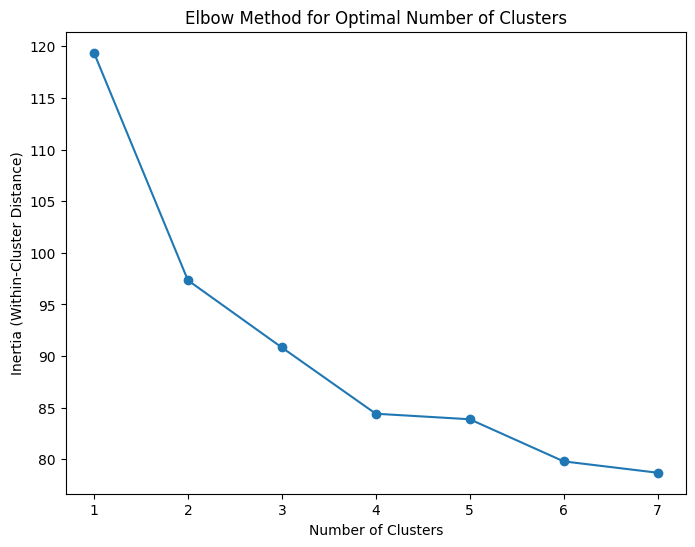

In [4]:
# Use the elbow method to choose the number of clusters

# Define the range for possible number of clusters
inertia = []
cluster_range = range(1, 8)  # Test 1 to 10 clusters; adjust as needed

for n_clusters in cluster_range:
    model = TimeSeriesKMeans(n_clusters=n_clusters, metric="dtw", random_state=0)
    print(f"Modelling for cluster = {n_clusters} is done.")
    model.fit(time_series_data)
    inertia.append(model.inertia_)  # Append the inertia for each model

# Step 4: Plot the inertia to find the "elbow"
plt.figure(figsize=(8, 6))
plt.plot(cluster_range, inertia, marker='o')
plt.title("Elbow Method for Optimal Number of Clusters")
plt.xlabel("Number of Clusters")
plt.ylabel("Inertia (Within-Cluster Distance)")
plt.show()

## Graph (Smoothed)

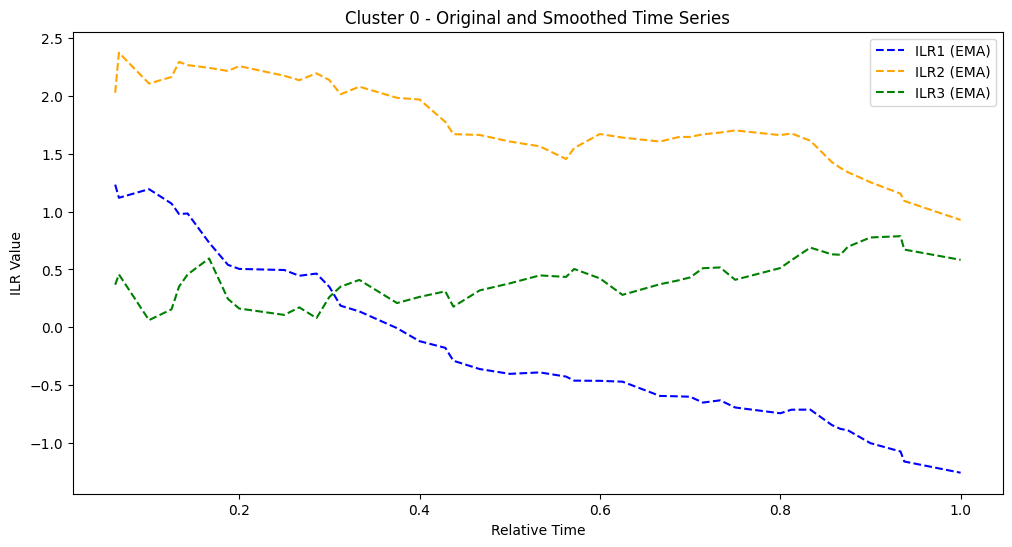

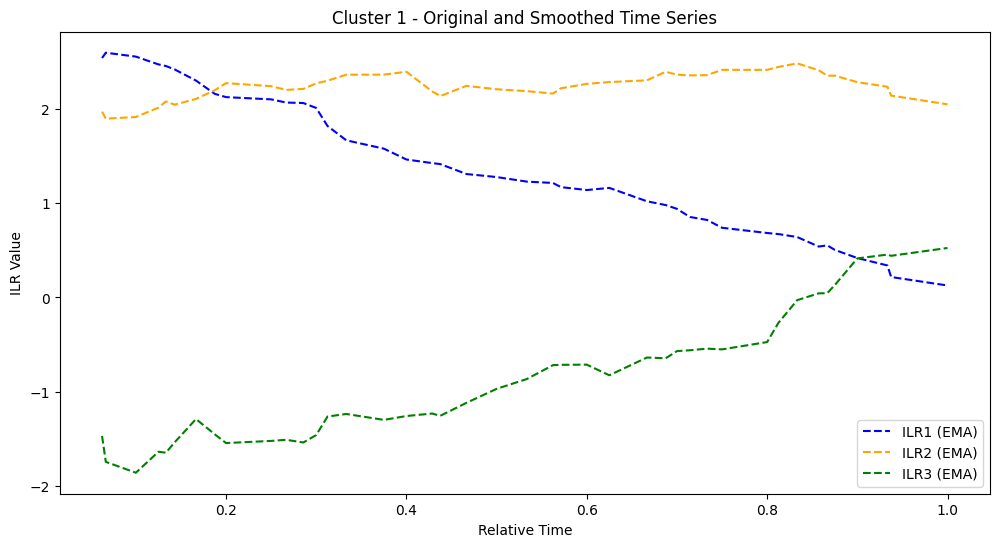

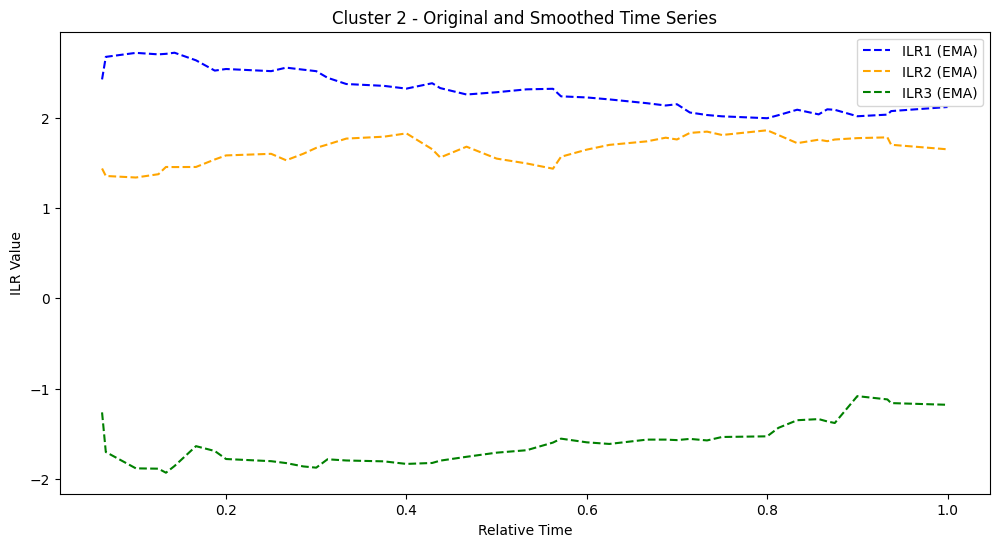

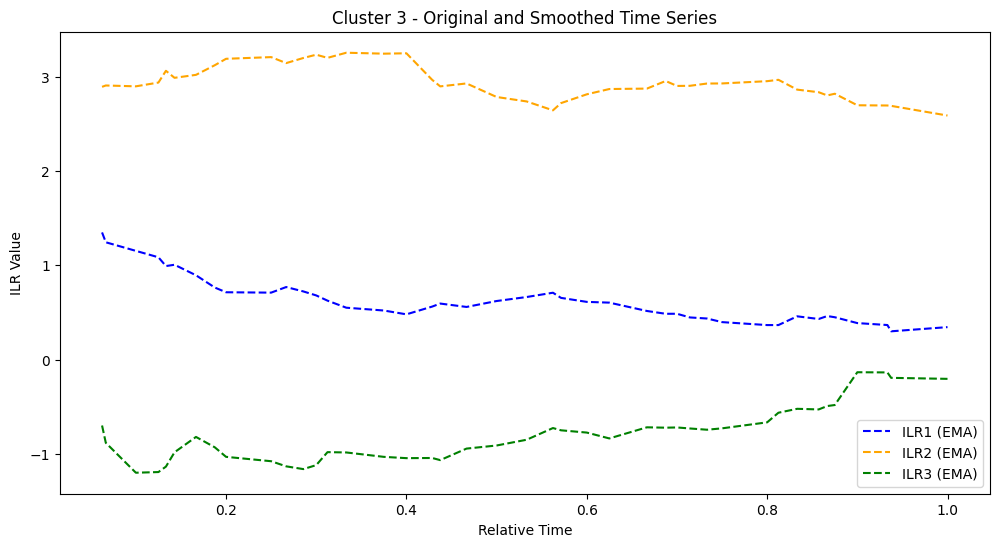

In [12]:
# Creating a relative time variable for each participant
df['relative_time'] = df.groupby('ID')['time'].transform(lambda x: x / x.max())

# Define the number of clusters (adjust to the actual number of clusters)
n_clusters = 4

# Smoothing parameters
alpha = 0.1  # Smoothing factor for EMA
savgol_window = 5  # Window length for Savitzky-Golay filter
savgol_polyorder = 2  # Polynomial order for Savitzky-Golay filter

for cluster in range(n_clusters):
    cluster_data = df[df['cluster'] == cluster]
    
    # Group by relative time and calculate the mean of ilr variables
    mean_relative = cluster_data.groupby('relative_time')[['ilr1', 'ilr2', 'ilr3']].mean()
    
    # Apply Exponential Moving Average (EMA) smoothing
    mean_ilr_smooth_ema = mean_relative.apply(lambda x: x.ewm(alpha=alpha).mean())
    
    # Apply Savitzky-Golay Filter smoothing
    mean_ilr_smooth_savgol = pd.DataFrame({
        "ilr1": savgol_filter(mean_relative["ilr1"], window_length=savgol_window, polyorder=savgol_polyorder),
        "ilr2": savgol_filter(mean_relative["ilr2"], window_length=savgol_window, polyorder=savgol_polyorder),
        "ilr3": savgol_filter(mean_relative["ilr3"], window_length=savgol_window, polyorder=savgol_polyorder)
    }, index=mean_relative.index)

    # Plot the original and smoothed series for each ILR variable in the cluster
    plt.figure(figsize=(12, 6))
    
    # Plot EMA smoothed series3
    plt.plot(mean_relative.index, mean_ilr_smooth_ema["ilr1"], label="ILR1 (EMA)", linestyle="--", color="blue")
    plt.plot(mean_relative.index, mean_ilr_smooth_ema["ilr2"], label="ILR2 (EMA)", linestyle="--", color="orange")
    plt.plot(mean_relative.index, mean_ilr_smooth_ema["ilr3"], label="ILR3 (EMA)", linestyle="--", color="green")


    # Plot Savitzky-Golay smoothed series
    #plt.plot(mean_relative.index, mean_ilr_smooth_savgol["ilr1"], label="ILR1 (Savitzky-Golay)", linestyle="-.", color="blue")
    #plt.plot(mean_relative.index, mean_ilr_smooth_savgol["ilr2"], label="ILR2 (Savitzky-Golay)", linestyle="-.", color="orange")
    #plt.plot(mean_relative.index, mean_ilr_smooth_savgol["ilr3"], label="ILR3 (Savitzky-Golay)", linestyle="-.", color="green")
    
    # Formatting the plot
    plt.xlabel("Relative Time")
    plt.ylabel("ILR Value")
    plt.title(f"Cluster {cluster} - Original and Smoothed Time Series")
    plt.legend()
    plt.show()

In [6]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.signal import savgol_filter

# Assuming 'df' contains your data and is already prepared with 'relative_time' and cluster labels
# Creating a relative time variable for each participant
df['relative_time'] = df.groupby('ID')['time'].transform(lambda x: x / x.max())

# Define the number of clusters (adjust to the actual number of clusters)
n_clusters = 4

# Smoothing parameters
alpha = 0.05  # Smoothing factor for EMA
savgol_window = 5  # Window length for Savitzky-Golay filter
savgol_polyorder = 2  # Polynomial order for Savitzky-Golay filter

for cluster in range(n_clusters):
    cluster_data = df[df['cluster'] == cluster]
    
    # Group by relative time and calculate the mean of ilr variables
    mean_relative = cluster_data.groupby('relative_time')[['ilr1', 'ilr2', 'ilr3']].mean()
    
    # Apply Exponential Moving Average (EMA) smoothing
    mean_ilr_smooth_ema = mean_relative.apply(lambda x: x.ewm(alpha=alpha).mean())
    
    # Apply Savitzky-Golay Filter smoothing
    mean_ilr_smooth_savgol = pd.DataFrame({
        "ilr1": savgol_filter(mean_relative["ilr1"], window_length=savgol_window, polyorder=savgol_polyorder),
        "ilr2": savgol_filter(mean_relative["ilr2"], window_length=savgol_window, polyorder=savgol_polyorder),
        "ilr3": savgol_filter(mean_relative["ilr3"], window_length=savgol_window, polyorder=savgol_polyorder)
    }, index=mean_relative.index)

    # Plot the original and smoothed series for each ILR variable in the cluster
    plt.figure(figsize=(12, 6))
    
    # Plot EMA smoothed series3
    plt.plot(mean_relative.index, mean_ilr_smooth_ema["ilr1"], label="ILR1 (EMA)", linestyle="--", color="blue")
    plt.plot(mean_relative.index, mean_ilr_smooth_ema["ilr2"], label="ILR2 (EMA)", linestyle="--", color="orange")
    plt.plot(mean_relative.index, mean_ilr_smooth_ema["ilr3"], label="ILR3 (EMA)", linestyle="--", color="green")


    # Plot Savitzky-Golay smoothed series
    #plt.plot(mean_relative.index, mean_ilr_smooth_savgol["ilr1"], label="ILR1 (Savitzky-Golay)", linestyle="-.", color="blue")
    #plt.plot(mean_relative.index, mean_ilr_smooth_savgol["ilr2"], label="ILR2 (Savitzky-Golay)", linestyle="-.", color="orange")
    #plt.plot(mean_relative.index, mean_ilr_smooth_savgol["ilr3"], label="ILR3 (Savitzky-Golay)", linestyle="-.", color="green")
    
    # Formatting the plot
    plt.xlabel("Relative Time")
    plt.ylabel("ILR Value")
    plt.title(f"Cluster {cluster} - Original and Smoothed Time Series")
    plt.legend()
    plt.show()

KeyError: 'cluster'

### Elbow

**Inertia Calculation**: The model.inertia_ attribute gives the sum of within-cluster distances for the given model, which helps in observing how the distances change with different cluster counts.

**Elbow Plot**: Look for the point where the plot of inertia vs. number of clusters starts to flatten, indicating diminishing returns for adding more clusters. This is typically your "elbow."

Interpreting the Elbow Plot:
- The optimal number of clusters is generally at the "elbow" point of the plot, where adding more clusters does not significantly reduce inertia.
- Choose the number of clusters right before the decrease in inertia slows down significantly.


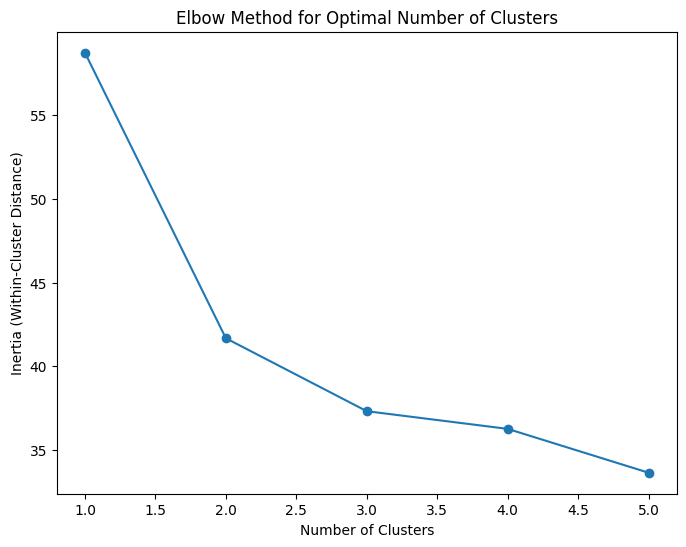

In [ ]:
# Step 1: Prepare your time series data as before
time_series_data = []
grouped = df.groupby("ID")

for participant, group in grouped:
    group_sorted = group.sort_values("time")
    time_series = group_sorted[['ilr1', 'ilr2', 'ilr3', 'excluded', 'injustice', 'personal', 'violence', 'Experiment']].values
    max_length = 16  # Adjust as appropriate for your dataset
    if len(time_series) < max_length:
        time_series = np.pad(time_series, ((0, max_length - len(time_series)), (0, 0)), 'constant', constant_values=np.nan)
    else:
        time_series = time_series[:max_length]
    time_series_data.append(time_series)

time_series_data = np.array(time_series_data)

# Step 2: Scale the data
scaled_data = TimeSeriesScalerMeanVariance().fit_transform(time_series_data)

# Step 3: Use the elbow method to choose the number of clusters
# Define the range for possible number of clusters
inertia = []
cluster_range = range(1, 10)  # Test 1 to 10 clusters; adjust as needed

for n_clusters in cluster_range:
    model = TimeSeriesKMeans(n_clusters=n_clusters, metric="dtw", random_state=0)
    model.fit(scaled_data)
    inertia.append(model.inertia_)  # Append the inertia for each model

# Step 4: Plot the inertia to find the "elbow"
plt.figure(figsize=(8, 6))
plt.plot(cluster_range, inertia, marker='o')
plt.title("Elbow Method for Optimal Number of Clusters")
plt.xlabel("Number of Clusters")
plt.ylabel("Inertia (Within-Cluster Distance)")
plt.show()

## Hierarchical with Normalizing per Experiment

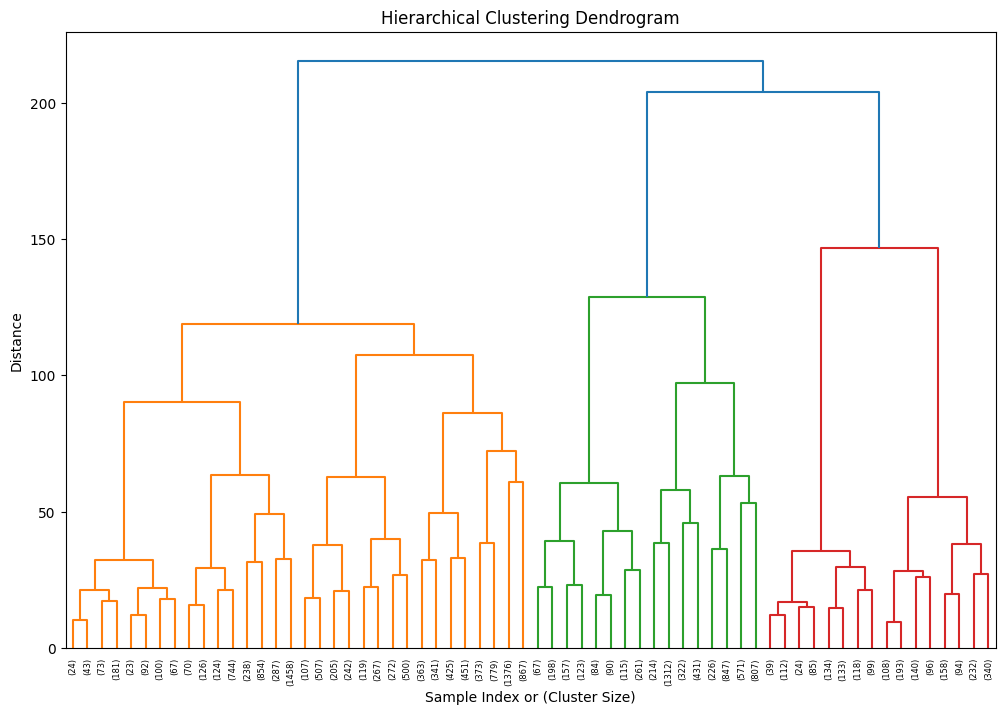

In [40]:
import pandas as pd
import numpy as np
from scipy.cluster.hierarchy import linkage, dendrogram, fcluster
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler

# Load your data
# df = pd.read_csv('your_data.csv')  # Replace with your actual data loading line if needed

# Step 1: Normalize DVs (ilr1, ilr2, ilr3) by Experiment
def normalize_by_experiment(df, dv_columns, group_column):
    """
    Normalize specified columns within groups defined by group_column.
    """
    normalized_df = df.copy()
    for col in dv_columns:
        # Normalize each DV column within each experiment
        normalized_df[col] = df.groupby(group_column)[col].transform(lambda x: (x - x.mean()) / x.std())
    return normalized_df

# Columns to normalize
dv_columns = ['ilr1', 'ilr2', 'ilr3']
df_normalized = normalize_by_experiment(df, dv_columns, 'Experiment')

# Step 2: Prepare Data for Clustering
clustering_data = df_normalized[dv_columns + ['excluded', 'injustice', 'personal', 'violence', 'Experiment']]

# Step 3: Standardize the Data for Clustering
scaler = StandardScaler()
clustering_data_scaled = scaler.fit_transform(clustering_data)

# Step 3.1: Check for any NaNs or Infinite values and replace them with 0
# This can prevent non-finite values from causing errors in the linkage function
clustering_data_scaled = np.nan_to_num(clustering_data_scaled, nan=0.0, posinf=0.0, neginf=0.0)

# Step 4: Perform Hierarchical Clustering
# Compute the linkage matrix
linkage_matrix = linkage(clustering_data_scaled, method='ward')

# Plot the dendrogram to inspect cluster distances
plt.figure(figsize=(12, 8))
dendrogram(linkage_matrix, truncate_mode='level', p=5)
plt.title('Hierarchical Clustering Dendrogram')
plt.xlabel('Sample Index or (Cluster Size)')
plt.ylabel('Distance')
plt.show()